# Homework 5
### ASTR-324, University of Washington


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall the MCMC lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then visually compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models. **There's no need to do quantitative model-comparison**.
- Use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can solve this problem by generalizing the code from class.

The data:

In [146]:
hw_done = True  

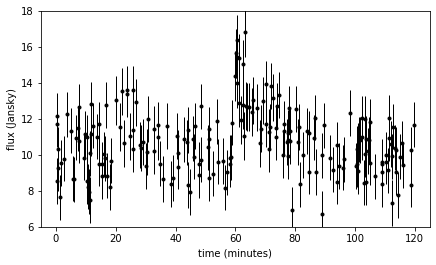

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# read data
data = np.loadtxt('data/burst.dataset.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import plot_mcmc
import pymc3 as pm

## One burst

In [3]:
traces = sample_model(two_bursts=False)
plot_traces(traces, figsize=(7, 7))

NameError: name 'sample_model' is not defined

In [3]:
# A utility function to convert the traces (chains) to a Pandas DataFrame
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

In [4]:
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

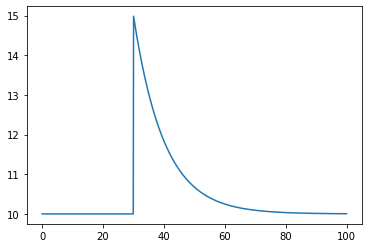

In [5]:
t_test = np.linspace(0,100,1000)
y_test = burst(t_test, b0 = 10, A = 5, alpha = 0.1, T = 30)
plt.plot(t_test, y_test)

In [123]:
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50)
    A = pm.Uniform('A', 0, 50)
    T = pm.Uniform('T', 0, 100)
    log_alpha = pm.Uniform('log_alpha', -10, 10)

    y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T), sd=sigma, observed=y_obs)

    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]
Sampling chain 0, 0 divergences: 100%|██████████| 26000/26000 [00:17<00:00, 1486.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


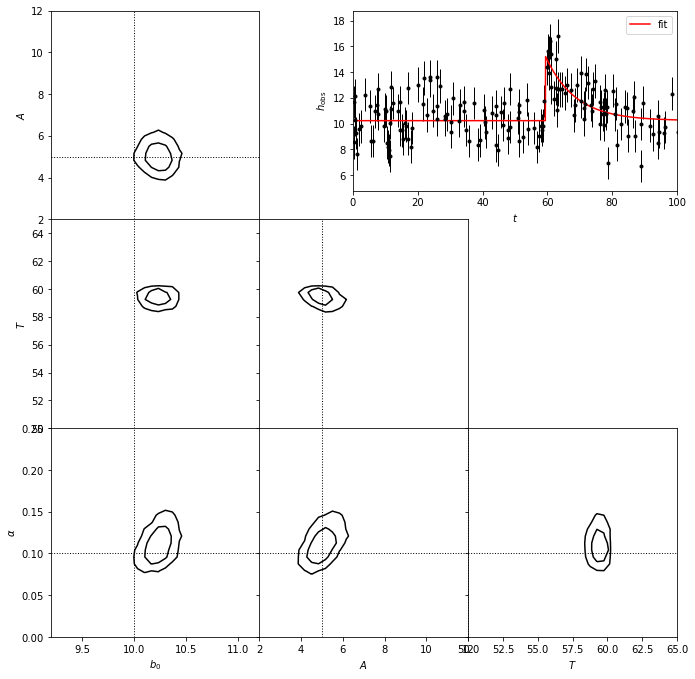

In [129]:
df = traces_to_pandas(traces, 1000)
df["alpha"] = np.exp(traces['log_alpha'])
del df["log_alpha"]

variables = ['b0', 'A', 'T', 'alpha']
labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (50, 65), (0.0, 0.25)]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1000)
y_fit = burst(t_fit, **df.median())

ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_fit, '-k', label="fit", c='red')
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

## Two bursts

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha2]
>Metropolis: [T2]
>Metropolis: [A2]
>Metropolis: [log_alpha1]
>Metropolis: [T1]
>Metropolis: [A1]
>Metropolis: [b0]
Sampling chain 1, 0 divergences: 100%|██████████| 50500/50500 [01:24<00:00, 597.01it/s]
The number of effective samples is smaller than 10% for some parameters.


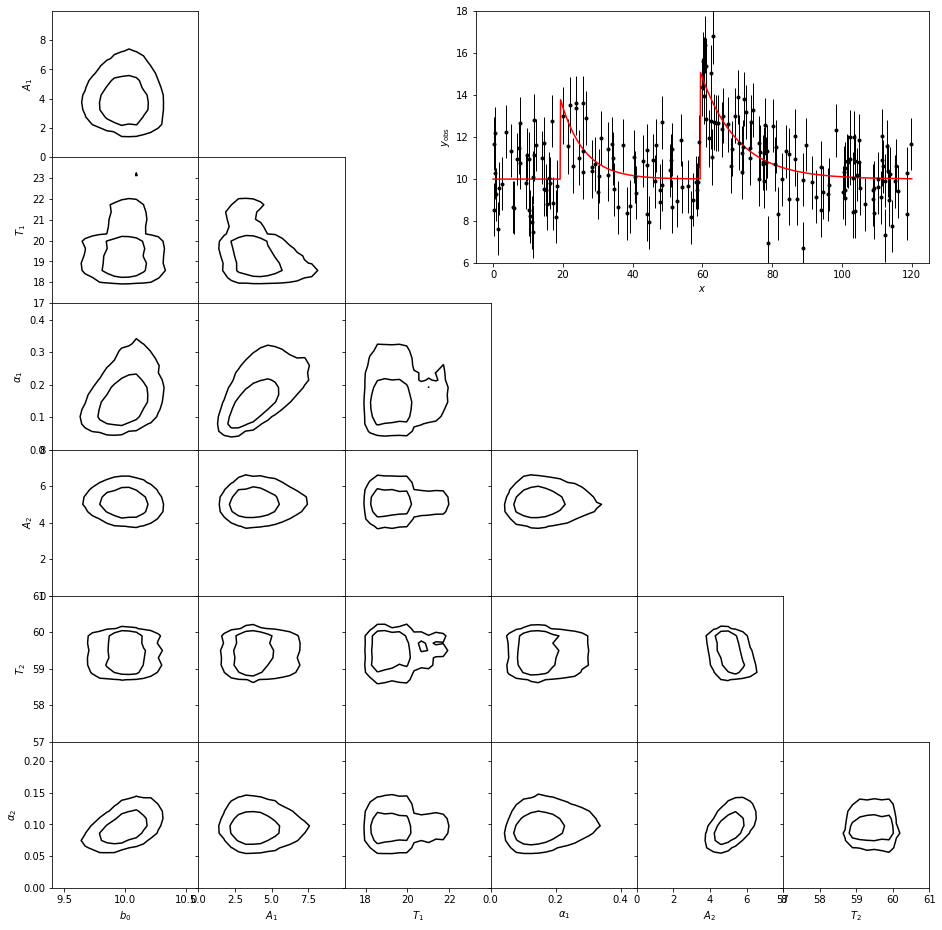

In [45]:
traces = sample_model(two_bursts=True)
plot_traces(traces)

In [7]:
# A utility function to convert the traces (chains) to a Pandas DataFrame
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

In [8]:
#... your solution here ...
def twoburst(t, b0, A1, A2, alpha1, alpha2, T1, T2 ):
    """Burst model"""
    mask1 = (t >= T1)
    mask2 = (t >= T2)
    y1 = b0 + mask1 * A1 * np.exp(-alpha1 * (t - T1))
    y2 = mask2 * A2 * np.exp(-alpha2 * (t - T2))
    y_tot = y1 + y2
    return y_tot

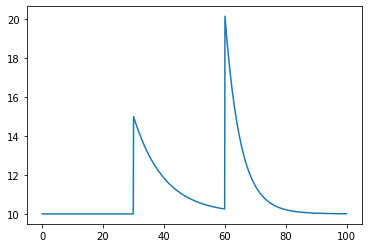

In [9]:
t_test = np.linspace(0,100,1000)
y_test = twoburst(t_test, b0 = 10, A1 = 5, A2 = 10, alpha1 = 0.1, alpha2 = 0.2, T1 = 30, T2 = 60)
plt.plot(t_test, y_test)

In [10]:
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50)
    A1 = pm.Uniform('A1', 0, 50)
    A2 = pm.Uniform('A2', 0, 20)
    T1 = pm.Uniform('T1', 0, 40)
    T2 = pm.Uniform('T2', 40, 80)
    log_alpha1 = pm.Uniform('log_alpha1', -10, 10) #decay of burst
    log_alpha2 = pm.Uniform('log_alpha2', -10, 10) #decay of burst
    
    y = pm.Normal('y', mu=twoburst(t, b0, A1, A2, np.exp(log_alpha1), np.exp(log_alpha2), T1, T2), sd=sigma_y, observed=y_obs)
    

    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha2]
>Metropolis: [log_alpha1]
>Metropolis: [T2]
>Metropolis: [T1]
>Metropolis: [A2]
>Metropolis: [A1]
>Metropolis: [b0]
Sampling chain 0, 0 divergences: 100%|██████████| 26000/26000 [00:38<00:00, 675.80it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


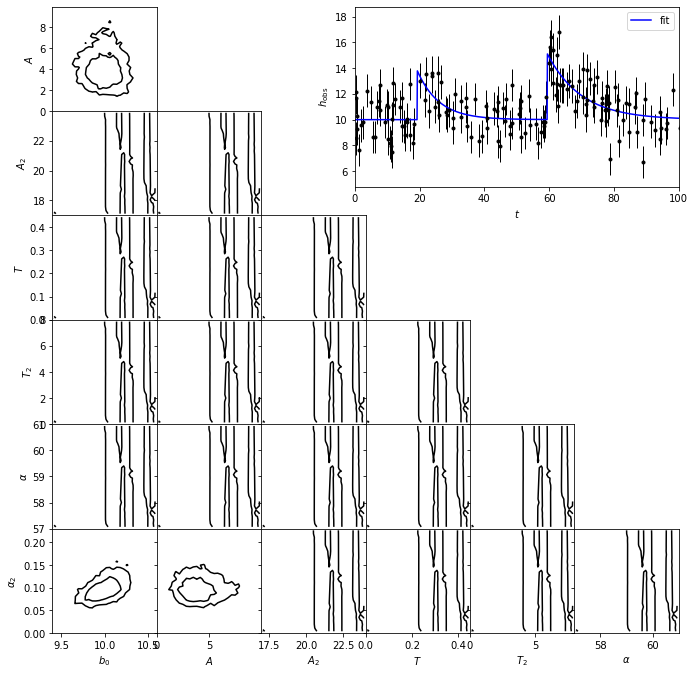

In [11]:
df = traces_to_pandas(traces, 1000)
df["alpha1"] = np.exp(traces['log_alpha1'])
df["alpha2"] = np.exp(traces['log_alpha2'])
del df["log_alpha1"]
del df["log_alpha2"]

variables = ['b0', 'A1', 'A2', 'T1', 'T2', 'alpha1', 'alpha2']
labels = ['$b_0$', '$A$', '$A_2$', '$T$', '$T_2$', r'$\alpha$', r'$\alpha_2$']
limits =  [(9.4, 10.6), (0, 9.99), (16.99, 23.99), (0.0, 0.45), (0, 8.0), (57, 61), (0.0, 0.23)]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1000)
y_fit = twoburst(t_fit, **df.median())

ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_fit, '-k', label="fit", color = 'blue')
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()